In [2]:
%matplotlib widget

from collections import defaultdict
from dataclasses import dataclass, field
from itertools import product
from math import inf
from random import choice

import numpy as np

from numpy import int_, object_
from numpy.typing import NDArray

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

import re

from util import print_hex

COLORS = list(mcolors.CSS4_COLORS.keys())


<link href="style.css" rel="stylesheet"></link>
<main>
<article class="day-desc"><h2>--- Day 22: Sand Slabs ---</h2><p>Enough sand has fallen; it can finally filter water for Snow Island.</p>
<p>Well, <em>almost</em>.</p>
<p>The sand has been falling as large compacted <em>bricks</em> of sand, piling up to form an impressive stack here near the edge of Island Island. In order to make use of the sand to filter water, some of the bricks will need to be broken apart - nay, <em><span title="Disintegrate - X,R
Sorcery
Destroy X target bricks of sand. They cannot be regenerated. Create 32768 0/1 colorless Sand artifact creature tokens for each brick of sand destroyed in this way.">disintegrated</span></em> - back into freely flowing sand.</p>
<p>The stack is tall enough that you'll have to be careful about choosing which bricks to disintegrate; if you disintegrate the wrong brick, large portions of the stack could topple, which sounds pretty dangerous.</p>
<p>The Elves responsible for water filtering operations took a <em>snapshot of the bricks while they were still falling</em> (your puzzle input) which should let you work out which bricks are safe to disintegrate. For example:</p>
<pre><code>1,0,1~1,2,1
0,0,2~2,0,2
0,2,3~2,2,3
0,0,4~0,2,4
2,0,5~2,2,5
0,1,6~2,1,6
1,1,8~1,1,9
</code></pre>
<p>Each line of text in the snapshot represents the position of a single brick at the time the snapshot was taken. The position is given as two <code>x,y,z</code> coordinates - one for each end of the brick - separated by a tilde (<code>~</code>). Each brick is made up of a single straight line of cubes, and the Elves were even careful to choose a time for the snapshot that had all of the free-falling bricks at <em>integer positions above the ground</em>, so the whole snapshot is aligned to a three-dimensional cube grid.</p>
<p>A line like <code>2,2,2~2,2,2</code> means that both ends of the brick are at the same coordinate - in other words, that the brick is a single cube.</p>
<p>Lines like <code>0,0,10~1,0,10</code> or <code>0,0,10~0,1,10</code> both represent bricks that are <em>two cubes</em> in volume, both oriented horizontally. The first brick extends in the <code>x</code> direction, while the second brick extends in the <code>y</code> direction.</p>
<p>A line like <code>0,0,1~0,0,10</code> represents a <em>ten-cube brick</em> which is oriented <em>vertically</em>. One end of the brick is the cube located at <code>0,0,1</code>, while the other end of the brick is located directly above it at <code>0,0,10</code>.</p>
<p>The ground is at <code>z=0</code> and is perfectly flat; the lowest <code>z</code> value a brick can have is therefore <code>1</code>. So, <code>5,5,1~5,6,1</code> and <code>0,2,1~0,2,5</code> are both resting on the ground, but <code>3,3,2~3,3,3</code> was above the ground at the time of the snapshot.</p>
<p>Because the snapshot was taken while the bricks were still falling, some bricks will <em>still be in the air</em>; you'll need to start by figuring out where they will end up. Bricks are magically stabilized, so they <em>never rotate</em>, even in weird situations like where a long horizontal brick is only supported on one end. Two bricks cannot occupy the same position, so a falling brick will come to rest upon the first other brick it encounters.</p>
<p>Here is the same example again, this time with each brick given a letter so it can be marked in diagrams:</p>
<pre><code>1,0,1~1,2,1   &lt;- A
0,0,2~2,0,2   &lt;- B
0,2,3~2,2,3   &lt;- C
0,0,4~0,2,4   &lt;- D
2,0,5~2,2,5   &lt;- E
0,1,6~2,1,6   &lt;- F
1,1,8~1,1,9   &lt;- G
</code></pre>
<p>At the time of the snapshot, from the side so the <code>x</code> axis goes left to right, these bricks are arranged like this:</p>
<pre><code> x
012
.G. 9
.G. 8
... 7
FFF 6
..E 5 z
D.. 4
CCC 3
BBB 2
.A. 1
--- 0
</code></pre>
<p>Rotating the perspective 90 degrees so the <code>y</code> axis now goes left to right, the same bricks are arranged like this:</p>
<pre><code> y
012
.G. 9
.G. 8
... 7
.F. 6
EEE 5 z
DDD 4
..C 3
B.. 2
AAA 1
--- 0
</code></pre>
<p>Once all of the bricks fall downward as far as they can go, the stack looks like this, where <code>?</code> means bricks are hidden behind other bricks at that location:</p>
<pre><code> x
012
.G. 6
.G. 5
FFF 4
D.E 3 z
??? 2
.A. 1
--- 0
</code></pre>
<p>Again from the side:</p>
<pre><code> y
012
.G. 6
.G. 5
.F. 4
??? 3 z
B.C 2
AAA 1
--- 0
</code></pre>
<p>Now that all of the bricks have settled, it becomes easier to tell which bricks are supporting which other bricks:</p>
<ul>
<li>Brick <code>A</code> is the only brick supporting bricks <code>B</code> and <code>C</code>.</li>
<li>Brick <code>B</code> is one of two bricks supporting brick <code>D</code> and brick <code>E</code>.</li>
<li>Brick <code>C</code> is the other brick supporting brick <code>D</code> and brick <code>E</code>.</li>
<li>Brick <code>D</code> supports brick <code>F</code>.</li>
<li>Brick <code>E</code> also supports brick <code>F</code>.</li>
<li>Brick <code>F</code> supports brick <code>G</code>.</li>
<li>Brick <code>G</code> isn't supporting any bricks.</li>
</ul>
<p>Your first task is to figure out <em>which bricks are safe to disintegrate</em>. A brick can be safely disintegrated if, after removing it, <em>no other bricks</em> would fall further directly downward. Don't actually disintegrate any bricks - just determine what would happen if, for each brick, only that brick were disintegrated. Bricks can be disintegrated even if they're completely surrounded by other bricks; you can squeeze between bricks if you need to.</p>
<p>In this example, the bricks can be disintegrated as follows:</p>
<ul>
<li>Brick <code>A</code> cannot be disintegrated safely; if it were disintegrated, bricks <code>B</code> and <code>C</code> would both fall.</li>
<li>Brick <code>B</code> <em>can</em> be disintegrated; the bricks above it (<code>D</code> and <code>E</code>) would still be supported by brick <code>C</code>.</li>
<li>Brick <code>C</code> <em>can</em> be disintegrated; the bricks above it (<code>D</code> and <code>E</code>) would still be supported by brick <code>B</code>.</li>
<li>Brick <code>D</code> <em>can</em> be disintegrated; the brick above it (<code>F</code>) would still be supported by brick <code>E</code>.</li>
<li>Brick <code>E</code> <em>can</em> be disintegrated; the brick above it (<code>F</code>) would still be supported by brick <code>D</code>.</li>
<li>Brick <code>F</code> cannot be disintegrated; the brick above it (<code>G</code>) would fall.</li>
<li>Brick <code>G</code> <em>can</em> be disintegrated; it does not support any other bricks.</li>
</ul>
<p>So, in this example, <code><em>5</em></code> bricks can be safely disintegrated.</p>
<p>Figure how the blocks will settle based on the snapshot. Once they've settled, consider disintegrating a single brick; <em>how many bricks could be safely chosen as the one to get disintegrated?</em></p>
</article>

</main>


grid (x, y): 
......
......
......
###...
###...
###...

grid (x, z): 
.#....
.#....
###...
#.#...
###...
.#....

grid (y, z): 
.#....
.#....
.#....
###...
#.#...
###...


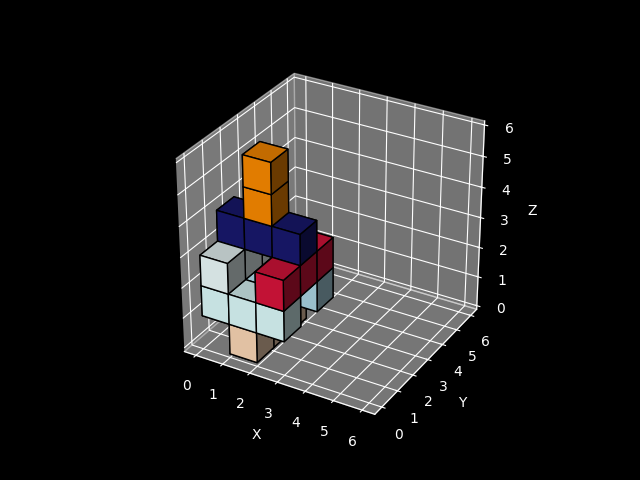

5


In [3]:
from __future__ import annotations
from ast import parse
from collections import deque
from functools import total_ordering
from typing import Generator


snapshot = """
1,0,1~1,2,1
0,0,2~2,0,2
0,2,3~2,2,3
0,0,4~0,2,4
2,0,5~2,2,5
0,1,6~2,1,6
1,1,8~1,1,9
"""


@total_ordering
@dataclass(eq=False, frozen=True, slots=True, unsafe_hash=True)
class Cell:
    x: int
    y: int
    z: int

    def __eq__(self, other: Cell):
        return (self.x, self.y, self.z) == (other.x, other.y, other.z)

    def __lt__(self, other: Cell):
        return (self.z, self.x, self.y) < (other.z, other.x, other.y)

    def __iter__(self):
        return iter((self.x, self.y, self.z))


@dataclass(frozen=True, order=True, slots=True)
class Brick:
    left_front: Cell
    right_end: Cell
    color: str = field(compare=False, default_factory=lambda: choice(COLORS))

    def fall(self) -> Brick:
        return Brick(
            Cell(self.left_front.x, self.left_front.y, self.left_front.z - 1),
            Cell(self.right_end.x, self.right_end.y, self.right_end.z - 1),
            self.color,
        )

    def overlaps(self, other: Brick) -> bool:
        return len(set(self.cells()) & set(other.cells())) != 0

    def cells(self) -> Generator[tuple[int, int, int]]:
        return product(
            range(self.left_front.x, self.right_end.x + 1),
            range(self.left_front.y, self.right_end.y + 1),
            range(self.left_front.z, self.right_end.z + 1),
        )


@dataclass(init=False)
class Grid:
    bricks: list[Brick]

    def __init__(self, snapshot: str) -> None:
        self.bricks = self.parse(snapshot)
        self.bricks.sort()
        self.supports = defaultdict(set[Brick])
        self.supported_by = defaultdict(set[Brick])
        self.settle()

    def settle(self):
        grid = {}
        for i in range(len(self.bricks)):
            current = self.bricks[i]
            nxt = current.fall()
            overlaps = [grid[cell] for cell in nxt.cells() if cell in grid]
            while nxt.left_front.z >= 0 and not overlaps:
                # print(f'{current=}')
                current = nxt
                nxt = nxt.fall()
                overlaps = [grid[cell] for cell in nxt.cells() if cell in grid]

            self.supports[current]
            for cell in current.cells():
                grid[cell] = current
            for f in overlaps:
                self.supports[f].add(current)
                self.supported_by[current].add(f)

            self.bricks[i] = current

    def desintegrate(self) -> list[int]:
        def climb(level: set[Brick]) -> int:
            if not level:
                return 0

            next_level = set()
            for supporter in level:
                for supported in self.supports[supporter]:
                    if self.supported_by[supported] <= level:
                        next_level.add(supported)

            return len(next_level) + climb(next_level)

        bricks_will_fall = [0] * len(self.bricks)

        for i, brick in enumerate(self.bricks):
            bricks_will_fall[i] = climb({brick})

        return bricks_will_fall

    def bricks_can_be_removed_safely(self):
        return sum(1 for c in self.desintegrate() if not c)

    def total_falling_bricks(self):
        def climb_up(level: set[Brick], falling: set[Brick]) -> int:
            if not level:
                return 0
            new_level = set()
            for b in level:
                for bs in self.supports[b]:
                    if (self.supported_by[bs] - falling) <= level:
                        new_level.add(bs)

            return len(new_level) + climb_up(new_level, falling | new_level)

        return sum(climb_up({b}, {b}) for b in self.bricks)

    @classmethod
    def parse(cls, snapshot: str) -> list[list[Brick]]:
        bricks = []
        for line in snapshot.strip().splitlines():
            front, back = line.split("~")
            front = Cell(*[int(i) for i in front.split(",")])
            back = Cell(*[int(i) for i in back.split(",")])
            bricks.append(Brick(front, back))
        return bricks

    def plot(self):
        nx = max(b.right_end.x for b in self.bricks) + 1
        ny = max(b.right_end.y for b in self.bricks) + 1
        nz = max(b.right_end.z for b in self.bricks) + 1
        dim = max(nx, ny, nz)

        grid = np.zeros(shape=(dim, dim, dim))
        colors = np.empty(shape=(dim, dim, dim), dtype=object)

        for brick in self.bricks:
            for cell in brick.cells():
                x, y, z = cell
                grid[x][y][z] = 1
                colors[x][y][z] = brick.color

        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_aspect("equal")

        ax.voxels(grid, facecolors=colors, edgecolor="k")

        plt.show()

    def print(self):
        d = (
            max(
                max(b.right_end.x for b in self.bricks),
                max(b.right_end.y for b in self.bricks),
                max(b.right_end.z for b in self.bricks),
            )
            + 1
        )

        xy = [[" " for _ in range(d)] for _ in range(d)]
        xz = [[" " for _ in range(d)] for _ in range(d)]
        yz = [[" " for _ in range(d)] for _ in range(d)]

        for brick in self.bricks:
            for x, y, z in brick.cells():
                xy[y][x] = brick.color
                xz[z][x] = brick.color
                yz[z][y] = brick.color

        print("grid (x, y): ")
        for line in reversed(xy):
            for ch in line:
                if len(ch) == 1:
                    print(".", end="")
                else:
                    print_hex(mcolors.CSS4_COLORS[ch], "#", end="")
            print()
        print()
        print("grid (x, z): ")
        for line in reversed(xz):
            for ch in line:
                if len(ch) == 1:
                    print(".", end="")
                else:
                    print_hex(mcolors.CSS4_COLORS[ch], "#", end="")
            print()
        print()
        print("grid (y, z): ")
        for line in reversed(yz):
            for ch in line:
                if len(ch) == 1:
                    print(".", end="")
                else:
                    print_hex(mcolors.CSS4_COLORS[ch], "#", end="")
            print()


g = Grid(snapshot)
g.print()
g.plot()
print(f"{g.bricks_can_be_removed_safely()}")

In [4]:
with open("../input/day22.txt") as f:
    g2 = Grid(f.read())
    print(f"{g2.bricks_can_be_removed_safely()=}")
#  si slow because of immutablilty

g2.bricks_can_be_removed_safely()=441


<link href="style.css" rel="stylesheet"></link>
<main>

<p>Your puzzle answer was <code>441</code>.</p><p class="day-success">The first half of this puzzle is complete! It provides one gold star: *</p>
<article class="day-desc"><h2 id="part2">--- Part Two ---</h2><p>Disintegrating bricks one at a time isn't going to be fast enough. While it might sound dangerous, what you really need is a <em>chain reaction</em>.</p>
<p>You'll need to figure out the best brick to disintegrate. For each brick, determine how many <em>other bricks would fall</em> if that brick were disintegrated.</p>
<p>Using the same example as above:</p>
<ul>
<li>Disintegrating brick <code>A</code> would cause all <code><em>6</em></code> other bricks to fall.</li>
<li>Disintegrating brick <code>F</code> would cause only <code><em>1</em></code> other brick, <code>G</code>, to fall.</li>
</ul>
<p>Disintegrating any other brick would cause <em>no other bricks</em> to fall. So, in this example, the sum of <em>the number of other bricks that would fall</em> as a result of disintegrating each brick is <code><em>7</em></code>.</p>
<p>For each brick, determine how many <em>other bricks</em> would fall if that brick were disintegrated. <em>What is the sum of the number of other bricks that would fall?</em></p>
</article>

</main>


In [6]:
g.total_falling_bricks()

7

In [7]:
g2.total_falling_bricks()

80778

<main>

<p>Your puzzle answer was <code>80778</code>.</p><p class="day-success">Both parts of this puzzle are complete! They provide two gold stars: **</p>
<p>At this point, you should <a href="/2023">return to your Advent calendar</a> and try another puzzle.</p>
<p>If you still want to see it, you can <a href="22/input" target="_blank">get your puzzle input</a>.</p>
<p>You can also <span class="share">[Share<span class="share-content">on
  <a href="https://twitter.com/intent/tweet?text=I%27ve+completed+%22Sand+Slabs%22+%2D+Day+22+%2D+Advent+of+Code+2023&amp;url=https%3A%2F%2Fadventofcode%2Ecom%2F2023%2Fday%2F22&amp;related=ericwastl&amp;hashtags=AdventOfCode" target="_blank">Twitter</a>
  <a href="javascript:void(0);" onclick="var ms; try{ms=localStorage.getItem('mastodon.server')}finally{} if(typeof ms!=='string')ms=''; ms=prompt('Mastodon Server?',ms); if(typeof ms==='string' &amp;&amp; ms.length){this.href='https://'+ms+'/share?text=I%27ve+completed+%22Sand+Slabs%22+%2D+Day+22+%2D+Advent+of+Code+2023+%23AdventOfCode+https%3A%2F%2Fadventofcode%2Ecom%2F2023%2Fday%2F22';try{localStorage.setItem('mastodon.server',ms);}finally{}}else{return false;}" target="_blank">Mastodon</a></span>]</span> this puzzle.</p>
</main>
